<a href="https://colab.research.google.com/github/penkovgd/itmo-ml-course/blob/main/lab3_trees_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений и композиции

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pprint import pprint

В этой лабораторной вам предстоит поработать с классификацией. Задача классификации в машинном обучении - это один из основных типов задач, где модель обучается предсказывать категориальную метку или класс для заданного входного наблюдения на основе обучающего набора данных, содержащего пары "входные данные - целевая метка".

Можно выделить несколько видов классификации:

* Binary - целевой признак имеет метку 0/1;
* Multiclass - целевой признак имеет метку из ограниченного множества (0, 1, 2, 3...);
* Multilabel - целевой признак может иметь несколько меток одновременно.

Классификацию можно решать как задачу регрессии (задача предсказания значения из непрерывного множества), затем выбирая порог - всем значениям меньше порога будет присвоена метка 0, всем значениям выше - метка 1.

# Деревья решений

Решающие деревья - алгоритм машинного обучения, с помощью которого можно решать задачи классификации и регрессии. Основная идея алгортитма - это поиск условий принятия решений по тренировочным данным.

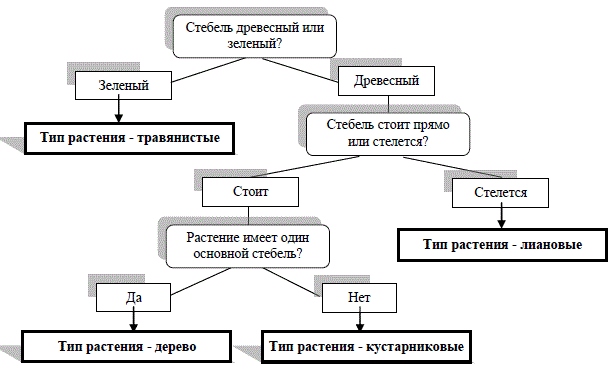

По сути, мы рекурсивно разбиваем наши обучающие данные по значениям определенного столбца, чтобы по итогу в каждом листе оказались наиболее однородные значения целевой переменной.

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки.
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вершину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$


Небольшое дополнение, чтобы стало понятнее: $Q$ - это функционал, который определяет то, что мы называем "наилучшим разбиением" для данных на каждом шаге. То есть мы выбираем один столбец, потом для него выбираем число $t$ такое, что часть значений столбца меньше $t$, а оставшаяся часть - больше или равна (дерево работает только с числовыми значениями или с категориальными, если они переведены в числовой формат), и смотрим, что случилось с целевой переменной при таком разбиении. Если допустить, что целевая переменная бинарная (0/1) и до разбиения нолики и единички лежали кучей, то после разбиения мы в идеале хотим получить две кучки, где в одной только нули, а в другой только единицы.

## Функционал качества для деревьев решений


Для классификации чаще всего предлагают следующие два:

- энтропия Шеннона: $-\sum_k{p_{ik}log_2(p_{ik})}$

- индекс Джини: $\sum_{j\neq k}p_{ij}p_{ik} = 1 - \sum_k p_{ik}^2$

где $i$ - ID узлов дерева;

$k, j$ - идентификаторы классов, представленных в датасете;

$p_{ik} = \frac{N_{ik}}{N_i}$,

$p_{ik}$ - вероятность принадлежности класса $k$ узлу $i$,

$N_{ik}$ - число объектов класса $k$ в узле $i$,

$N_{i}$ - общее число объектов в узле $i$.



Оба функционала позволяют определить степень хаоса в системе. Интуитивно:
* 0101101010101 - высокая степень хаоса
* 0000010010000 - средняя степень хаоса
* 0000000000000 - низкая степень хаоса

И с помощью дерева для целевой переменной мы хотим добиться чего-то вроде:
0001100011111 -> 00011000 + 11111 -> 000 + 11000 + 11111 -> 000 + 11 + 000 + 11111

Реализуйте функционалы.

In [ ]:
def entropy(y):  # y - массив значений целевой переменной
    y = np.array(y)
    classes = np.unique(y)
    p = np.array([len(y[y == k]) / len(y) for k in classes])
    entropy = -np.sum(p * np.log2(p))
    return entropy


def gini_index(y: list):
    y = np.array(y)
    classes = np.unique(y)
    p = np.array([len(y[y == k]) / len(y) for k in classes])
    gini = 1 - np.sum(p**2)
    return gini

In [ ]:
# Tests

assert np.isclose(entropy([0, 1, 0, 1, 0, 1]), 1.0)
assert np.isclose(entropy([0, 0, 0, 0, 0, 1]), 0.65, rtol=1e5)
assert np.isclose(entropy([0, 1, 2, 0, 1, 2, 0, 1, 2]), 1.58, rtol=1e5)

assert np.isclose(gini_index([0, 1, 0, 1, 0, 1]), 0.5)
assert np.isclose(gini_index([0, 0, 0, 0, 0, 1]), 0.27, rtol=1e5)
assert np.isclose(gini_index([0, 1, 2, 0, 1, 2, 0, 1, 2]), 0.66, rtol=1e5)

assert entropy([0, 0, 0, 0, 0, 0]) == gini_index([0, 0, 0, 0, 0, 0]) == 0.0

print("All tests passed successfully!")

All tests passed successfully!


Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер.

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


## Задание 1 (5 баллов)

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения узлов дерева (используйте, например, `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три разных критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

В классе `Tree` реализуйте метод `predict` (на вход метода подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою). Обратите внимание на то, что классы в датасете представлены одинаковым количеством объектов.

In [ ]:
from math import sqrt


class TreeNode:
    def __init__(self, S, depth=0) -> None:
        self.S: pd.DataFrame = S
        self.left_node: TreeNode | None = None
        self.right_node: TreeNode | None = None
        self.depth = depth

        self.split_feature = None
        self.split_t = None
        self.split_IG = -1

    def __repr__(self) -> str:
        if self.split_feature:
            return f"Node: {self.S.shape[0]}, impurity: {self.get_impurity():.3f}, {self.split_feature} < {self.split_t}"
        return f"Node: value: {self.S.shape[0]}, class: {self.get_class()}, impurity: {self.get_impurity():.3f}"

    def get_entropy(self, S: pd.DataFrame):
        return entropy(S["target"])

    def get_impurity(self):
        return entropy(self.S["target"])

    def get_class(self):
        classes, counts = np.unique(self.S["target"], return_counts=True)
        return classes[np.argmax(counts)]

    def split(self, min_samples=1):
        if self.S.shape[0] < 2:
            raise Exception("Нельзя поделить узел с выборкой меньше двух")
        H = self.get_entropy(self.S)
        features = self.S.drop(columns="target").columns

        # для случайного леса: выбираем sqrt(колво признаков) признаков при каждом сплите
        features = np.random.choice(features, size=int(sqrt(features.shape[0])))
        ###

        for feature in features:
            feature_sorted = self.S[feature].sort_values().unique()
            if feature_sorted.shape[0] == 1:
                thresholds = feature_sorted
            else:
                thresholds = (feature_sorted[:-1] + feature_sorted[1:]) / 2
            best_t, best_IG = thresholds[0], -1
            for t in thresholds:
                S_left = self.S[self.S[feature] < t]
                S_right = self.S[self.S[feature] >= t]
                H_left = self.get_entropy(S_left)
                H_right = self.get_entropy(S_right)
                IG = H - (
                    (S_left.size / self.S.size) * H_left
                    + (S_right.size / self.S.size) * H_right
                )
                if IG > best_IG:
                    best_IG = IG
                    best_t = t
            if best_IG > self.split_IG:
                self.split_IG = best_IG
                self.split_t = best_t
                self.split_feature = feature

        S_left = self.S[self.S[self.split_feature] < self.split_t]
        S_right = self.S[self.S[self.split_feature] >= self.split_t]

        if S_left.shape[0] < min_samples or S_right.shape[0] < min_samples:
            return None, None, None, None

        self.left_node = TreeNode(S_left)
        self.right_node = TreeNode(S_right)

        return self.split_feature, self.split_t, self.left_node, self.right_node


class Tree:
    def __init__(
        self, max_depth=5, min_samples_leaf=5, max_leaf_nodes=5, verbose=False
    ) -> None:
        self.root: TreeNode | None = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_leaf_nodes = max_leaf_nodes
        self.verbose = verbose

    def fit(self, X_train: pd.DataFrame, y_train: pd.DataFrame):
        df = X_train.copy()
        df["target"] = y_train
        self.root = TreeNode(df)
        leaves = [self.root]

        while len(leaves) < self.max_leaf_nodes:
            filtered_leaves = [
                leaf
                for leaf in leaves
                if leaf.depth < self.max_depth and leaf.get_impurity() > 0
            ]
            if not filtered_leaves:
                break
            selected_leaf = filtered_leaves[0]
            leaves.remove(selected_leaf)
            feature, t, left_node, right_node = selected_leaf.split(
                min_samples=self.min_samples_leaf
            )

            if left_node is None or right_node is None:
                continue
            if self.verbose:
                print(selected_leaf)
                print(f"    left: {left_node}")
                print(f"    right: {right_node}")

            left_node.depth = selected_leaf.depth + 1
            right_node.depth = selected_leaf.depth + 1

            leaves.append(left_node)
            leaves.append(right_node)

    def predict(self, X: pd.DataFrame):
        labels = np.empty(X.shape[0])
        for i, (_, x) in enumerate(X.iterrows()):
            current_node = self.root
            while current_node.left_node or current_node.right_node:  # пока не лист
                if x[current_node.split_feature] < current_node.split_t:
                    current_node = current_node.left_node
                else:
                    current_node = current_node.right_node
            labels[i] = current_node.get_class()
        return labels

Один из варинтов того, как может выглядеть дерево (в данном случае переобученное).

Вам не обязательно реализовывать функционал для визуализации, это просто пример. Но если хочется - посмотрите в сторону библиотеки [graphviz](https://graphviz.org/).


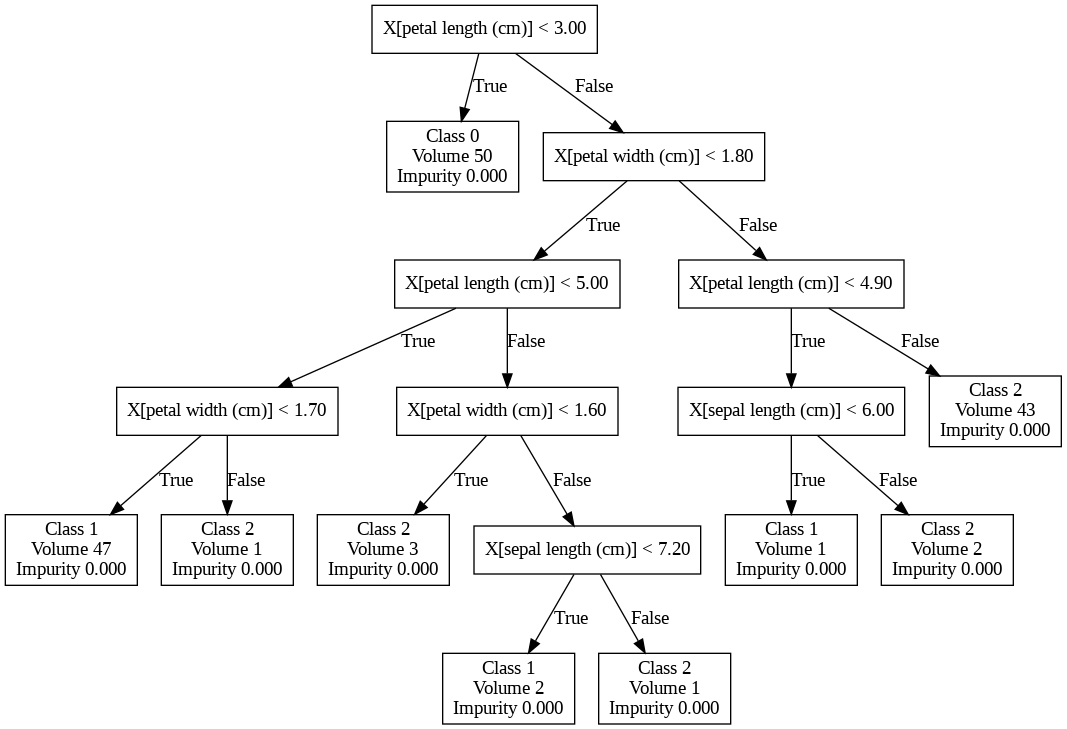

In [ ]:
from sklearn import datasets
from sklearn.model_selection import (
    train_test_split,
)  # при оценке вашего алгоритма не забудьте разбить данные на тренировочную и тестовую выборки
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.tree import (
    DecisionTreeClassifier,
)  # можете сравнить качество вашего алгоритма с реализацией "из коробки"


iris = datasets.load_iris()
X = iris["data"]
feature_names = iris["feature_names"]
y = iris["target"]
target_names = iris["target_names"]

X = pd.DataFrame(X, columns=feature_names)
y = pd.DataFrame(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

my_tree = Tree(max_depth=5, min_samples_leaf=5, max_leaf_nodes=5, verbose=True)
my_tree.fit(X_train, y_train)

sklearn_tree = DecisionTreeClassifier(
    criterion="entropy", max_depth=5, min_samples_leaf=5, max_leaf_nodes=5
)
sklearn_tree.fit(X_train, y_train)

Node: 105, impurity: 1.580, petal length (cm) < 2.35
    left: Node: value: 34, class: 0, impurity: -0.000
    right: Node: value: 71, class: 2, impurity: 0.993
Node: 71, impurity: 0.993, petal width (cm) < 1.75
    left: Node: value: 35, class: 1, impurity: 0.513
    right: Node: value: 36, class: 2, impurity: 0.183
Node: 36, impurity: 0.183, petal width (cm) < 1.85
    left: Node: value: 8, class: 2, impurity: 0.544
    right: Node: value: 28, class: 2, impurity: -0.000


DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=5,
                       min_samples_leaf=5)

In [ ]:
# my tree
y_pred = my_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.95      1.00      0.97        18
           2       1.00      0.91      0.95        11

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



In [ ]:
# sklearn tree
y_pred = sklearn_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.85      0.94      0.89        18
           2       0.89      0.73      0.80        11

    accuracy                           0.91        45
   macro avg       0.91      0.89      0.90        45
weighted avg       0.91      0.91      0.91        45



#  [Ансамбли](https://education.yandex.ru/handbook/ml/article/ansambli-v-mashinnom-obuchenii)




Суть ансамблей заключается в том, чтобы объединить предсказания стандартных моделей для повышения обобщающей способности или надёжности ансамбля перед одиночным стандартным методом машинного обучения.

Можно выделить следующие типы ансамблирования:

* Бэггинг. Однотипная модель строится по различным подвыборкам обучающих данных, затем результаты аггрегируются, например, с помощью усреднения. Для деревьев решений очень распространенным алгоритмом, использующим идею бэггинга, является случайный лес.

* Бустинг. Строится последовательность однотипных моделей, где каждая следующая призвана исправлять ошибки предыдущих. Самым распространенным алгоритмом бустинга является градиентный бустинг.

* Стэкинг. Строится несколько моделей разного типа, а также мета-модель, делающая итоговое предсказание на основании предсказаний моделей.

Для последующих заданий в качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Обратите внимание, что данные нуждаются в небольшой предобаботке, так как деревья работают только с числовыми признаками.


### Churn for Bank Customers

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "churn.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mathchi/churn-for-bank-customers",
    file_path,
)

c:\Users\George\Documents\itmo-ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\George\AppData\Local\Temp\ipykernel_9336\3052051244.py:6: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [ ]:
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])
y = df["Exited"]
X = df.drop(columns=["Exited"])
X


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [ ]:
categorical_cols = ["Geography", "Gender"]
X_encoded = pd.get_dummies(X, columns=categorical_cols, dtype=int)
X_encoded

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,1,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,0,1,0,0,1


In [ ]:
y.value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Видим дисбаланс классов (80 на 20%). Получается, что accuracy не очень подойдет. Выбор между Recall и Precision зависит от экономики - если дороже упустить клиента, которого модель не увидела (FN), то выбираем Recall. Если модель ложно предсказала уход клиента (FP) и мы тратим больше средсв на удержание клиента, который и так бы не ушел, то лучше выбрать Precision.

Допустим, нам важнее не пропустить уход клиента (FN), выбираем recall.

### Задание 2.1 (2 балла)

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи бэггинга:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализуйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества и другие. Выберите метрику, по которой вы будете сравнивать качество алгоритмов и кратко обоснуйте, почему вы выбрали именно её (в письменном формате).

Нельзя использовать готовую реализацию случайного леса из `sklearn`, но можно сопоставлять с ней качество вашего алгоритма.



In [ ]:
class RandomForest:
    def __init__(
        self,
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=1,
        max_leaf_nodes=None,
        criterion="gini",
    ):
        self.trees = []
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_leaf_nodes = max_leaf_nodes
        self.criterion = criterion

    def get_bootstrap_sample(self, X: pd.DataFrame, size=None) -> pd.DataFrame:
        if not size:
            size = X.shape[0]
        sample = X.iloc[np.random.randint(low=0, high=X.shape[0], size=size)]
        return sample

    def fit(self, X_train: pd.DataFrame, y_train: pd.DataFrame):
        df_train = X_train.copy()
        df_train["target"] = y_train
        for i in range(self.n_estimators):
            sample = self.get_bootstrap_sample(df_train)
            # tree = Tree(
            #     max_depth=self.max_depth,
            #     min_samples_leaf=self.min_samples_leaf,
            #     max_leaf_nodes=self.max_leaf_nodes,
            #     verbose=self.verbose,
            # )
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_leaf_nodes=self.max_leaf_nodes,
                max_features="sqrt",
                criterion=self.criterion,
                random_state=i,
            )
            sample_y = sample["target"]
            sample_X = sample.drop("target", axis=1)
            tree.fit(sample_X, sample_y)
            self.trees.append(tree)

    def predict(self, X_test: pd.DataFrame):
        y_preds = np.empty(
            (self.n_estimators, X_test.shape[0])
        )  # строка i - предсказания дерева i
        aggr_y_pred = np.empty((X_test.shape[0], 1))
        for i, tree in enumerate(self.trees):
            y_preds[i] = tree.predict(X_test)
        for i, preds in enumerate(
            y_preds.T
        ):  # итерируемся по колонкам: предсказания для одного и того же x_i разных деревьев
            values, counts = np.unique(preds, return_counts=True)
            most_freq_label = preds[np.argmax(counts)]
            aggr_y_pred[i] = most_freq_label
        return aggr_y_pred.astype(int)


In [ ]:
from sklearn.metrics import recall_score
import itertools


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=0
)

my_rf = RandomForest()

param_grid = {
    "n_estimators": [10, 50, 100, 200, 300, 500, 1000],
    "max_depth": [10, 50, 100, 200, 300, None],
    "min_samples_leaf": [1],
    "max_leaf_nodes": [None],
    "criterion": ["gini", "entropy"],
}

best_recall = 0
best_params = {}

for combo in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    rf = RandomForest(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_leaf=params["min_samples_leaf"],
        max_leaf_nodes=params["max_leaf_nodes"],
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    recall = recall_score(y_test, y_pred)

    if recall > best_recall:
        best_recall = recall
        best_params = params
        print(f"New best: Recall {best_recall:.4f} with {params}")


print("\nBest model:")
print(f"Recall: {best_recall:.4f}")
print("Parameters:", best_params)

New best: Recall 0.4509 with {'n_estimators': 10, 'max_depth': 10, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'criterion': 'gini'}
New best: Recall 0.5185 with {'n_estimators': 10, 'max_depth': 50, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'criterion': 'gini'}
New best: Recall 0.5217 with {'n_estimators': 10, 'max_depth': 50, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'criterion': 'entropy'}
New best: Recall 0.5411 with {'n_estimators': 10, 'max_depth': 100, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'criterion': 'gini'}
New best: Recall 0.5475 with {'n_estimators': 500, 'max_depth': 50, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'criterion': 'entropy'}

Best model:
Recall: 0.5475
Parameters: {'n_estimators': 500, 'max_depth': 50, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'criterion': 'entropy'}


In [ ]:
# sklearn random forest
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(
    **best_params,
    random_state=0,
    n_jobs=-1,
)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2379
           1       0.78      0.52      0.62       621

    accuracy                           0.87      3000
   macro avg       0.83      0.74      0.77      3000
weighted avg       0.86      0.87      0.86      3000



## Задание 2.2 (2 балла)

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента. Можно, например, использовать [SHAP](https://habr.com/ru/companies/wunderfund/articles/739744/) для анализа. Также основные способы для определения важности признаков моделей "из коробки" [описаны здесь](https://machinelearningmastery.com/calculate-feature-importance-with-python/).

In [ ]:
import shap

explainer = shap.Explainer(best_rf)
shap_values = explainer(X_test)

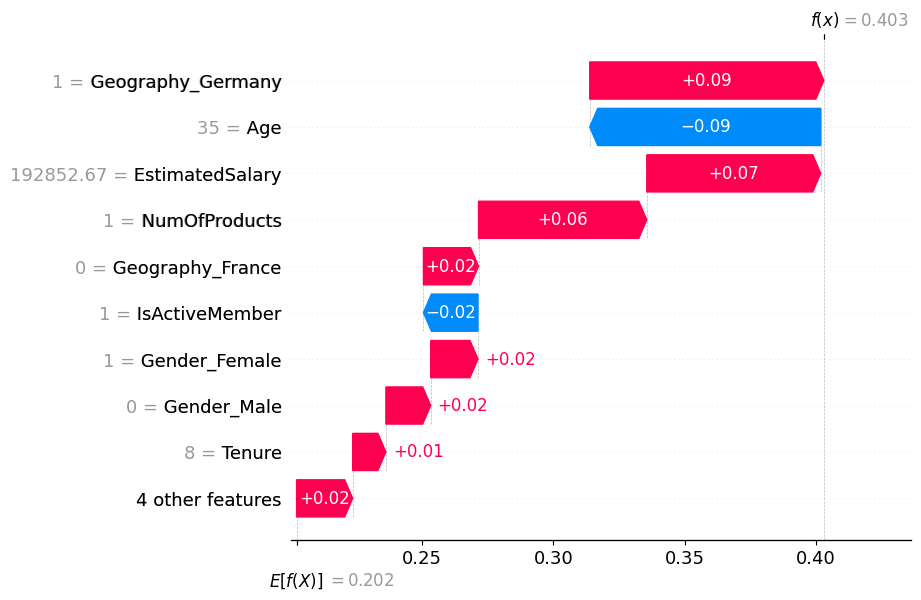

In [ ]:
shap.plots.waterfall(shap_values[0, :, 1])

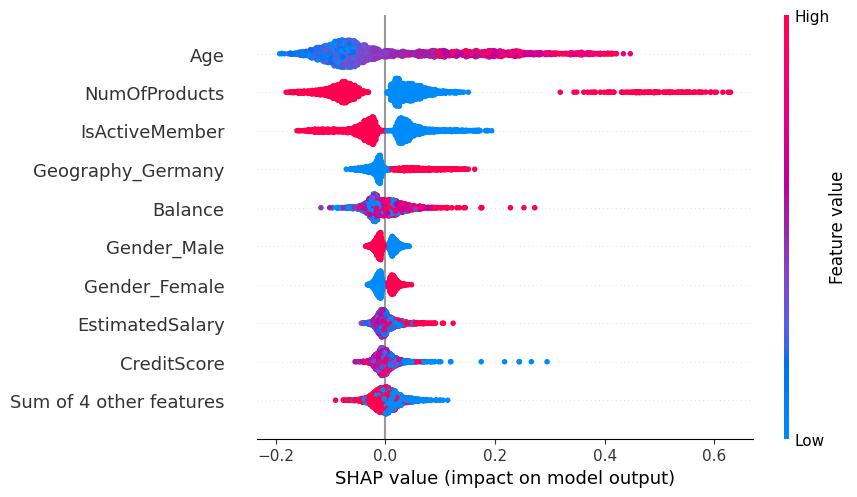

In [ ]:
shap.plots.beeswarm(shap_values[:, :, 1])

## Задание 3.1 (3 балла)

Вам необходимо будет реализовать алгоритм градиентного бустинга. В общем смысле бустинг заключается в том, чтобы тренировать каждую последующую модель так, чтобы она исправляла ошибки предыдущих.

Для работы алгоритма помимо данных нужны:
1. количество итераций $M \in \mathbb{N}$;
2. функция потерь $L(y,f)$, где $y$ - истинные значения, $f$ - полученная аппроксимация искомой функции (или просто предсказанные значения).
Важно, чтобы функция потерь была дифференцируемой по $f$;
3. базовая модель, на основе которой делается бустинг - будем использовать деревья решений;
4. начальное приближение $f_0(x)$ - чаще всего используют некую константу.

**Алгоритм:**
1. Задаём начальное приближение функции $f(x) = f_0(x)$ константой - в данном случае можно выбрать ноль, среднее по столбцу с целевым признаком или что-нибудь ещё.
2. Далее итеративно для $t$ от 1 до $M$:
    1. Считаем остатки как $\large r_{t} = -\left[\frac{\partial L(y, f(x))}{\partial f(x)}\right]_{f(x)=\hat{f}(x)}$
    2. Обучаем ещё одну базовую модель $h_t(x)$, при этом нецелевыми признаками у нас будет $x$, а в качестве целевого будем использовать остатки $r_t$, полученные на текущем шаге
    3. Находим оптимальный коэффициент $\rho_t = \underset{\rho}{\arg\min} \ L(y, \hat{f}(x) + \rho \cdot h(x))$
    4. Обновляем текущее приближение $\hat{f}(x) \leftarrow \hat{f}(x) + \hat{f}_i(x)$, где $\hat{f}_i(x) = \rho_t \cdot h_t(x)$
    5. Собираем все полученные базовые алгоритмы в модель $\hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x)$
    
    
  Коэффициенты $\rho_i$ искать не обязательно, их можно считать равными единице. Однако подбор коэффициентов позволит получить более точные значения, хотя и дополнительно нагрузит алгоритм с вычислительной точки зрения. Коэффициенты выбираются из какого-либо подмножества значений от -1 до 1.

**Функции потерь:**
- $L(y, f) = \frac{1}{2}(y - f)^2$ - _MSE-loss_. Используйте его если считаете, что у модели нет никаких дополнительных требований к стабильности.
- $L(y, f) = |y - f|$ - _MAE-loss_. Применять при требованиях к стабильности модели. Из минусов можно выделить то, что её немного сложнее дифференцировать.
- $\begin{equation} L(y, f) =\left \begin{array}{@{}ll@{}} (1 - \alpha) \cdot |y - f|, & если\ y-f \leq 0 \\ \alpha \cdot |y - f|, & если\ y-f >0 \end{array}\right. \end{equation}, \alpha \in (0,1)$ - $L_q$-loss. Применять при наличии особых требований к модели, например, когда нам нужно восстановить не среднее и не медиану условного распределения $(y|x)$, а какую-нибудь квантиль. Штрафует наблюдения, попадающие выше $\alpha$-той квантили.


Реализуйте предложенные функции потерь и их градиенты. В случае, если в вашей выборке не один объект, не забывайте нормировать значения функции потерь.


In [ ]:
def mse(y_real, y_predicted):
    # return np.sum((y_real - y_predicted) ** 2) / y_real.shape[0] / 2
    return np.sum((y_real - y_predicted) ** 2) / y_real.shape[0]


def mse_gradient(y_real, y_predicted):
    # return (y_predicted - y_real) / y_real.shape[0]
    return y_predicted - y_real
    # return 2 * (y_predicted - y_real)


def mae(y_real, y_predicted):
    return np.mean(np.abs(y_real - y_predicted))


def mae_gradient(y_real, y_predicted):
    # return np.sign(y_predicted - y_real) / y_real.shape[0]
    return np.sign(y_predicted - y_real)


def lq(y_real, y_predicted, q):
    diff = y_real - y_predicted
    return np.mean(np.where(diff > 0, q * diff, (q - 1) * diff))
    # return np.mean(np.max(q * (y_real - y_predicted), (1 - q) * (y_predicted - y_real)))


def lq_gradient(y_real, y_predicted, q=0.5):
    grad = np.where(y_real - y_predicted > 0, q - 1, q)
    grad = np.where(y_real - y_predicted == 0, 0, grad)
    # return grad / y_real.shape[0]
    return grad

In [ ]:
y_real = np.array([1, 2, 3, 4, 5])
y_predicted = np.array([1.2, 2.5, 2.8, 3.9, 5.1])

# Calculate metrics
mse_result = mse(y_real, y_predicted)
mae_result = mae(y_real, y_predicted)
lq_result = lq(y_real, y_predicted, q=0.8)

# Calculate gradients
mse_grad = mse_gradient(y_real, y_predicted)
mae_grad = mae_gradient(y_real, y_predicted)
lq_grad = lq_gradient(y_real, y_predicted, q=0.8)

# Tests
assert np.isclose(mse_result, 0.07)
assert np.isclose(mae_result, 0.21, rtol=1e5)
assert np.isclose(lq_result, 0.08, rtol=1e5)
assert np.allclose(mse_grad, np.array([0.4, 1, -0.4, -0.2, 0.2]))
assert np.allclose(mae_grad, np.array([1, 1, -1, -1, 1]))
assert np.allclose(lq_grad, np.array([0.8, 0.8, -0.2, -0.2, 0.8]))

print("Tests passed successfully!")

AssertionError: 

Реализуйте алгоритм градиентного бустинга со следующими параметрами:

* список, в котором вы будете хранить обученные деревья;
* параметры конструктора для деревьев (tree_kwargs);
* функция потерь;
* градиент функции потерь;
* bool параметр, означающий, является ли $\rho_i$ константой (единицей).

И методами:
* `fit` - в рамках этого метода вам необходимо будет строить деревья. Не забывайте передавать tree_kwargs;
* `predict` - этот метод должен последовательно применить обученные деревья для получения итогового ответа.

В качестве базового алгоритма используйте DecisionTreeRegressor из sklearn. Обычно для градиентного бустинга используют так называемые "пеньки" - деревья небольшой глубины. Это связано с тем, что алгоритм должен иметь высокую обобщающую способность и не переобучаться.


In [ ]:
from sklearn.tree import DecisionTreeRegressor


losses = {
    "MSE": (mse, mse_gradient),
    "MAE": (mae, mae_gradient),
    "lq": (lq, lq_gradient),
}


class GradientTreeBoosting:
    def __init__(self, loss: str, iterations=10, learning_rate=1, **tree_kwargs):
        self.trees = []
        self.loss_key = loss
        self.loss_dict = losses
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.tree_kwargs = tree_kwargs

    def get_gradient(self, y_real, y_pred):
        gradient_func = self.loss_dict[self.loss_key][1]
        return gradient_func(y_real, y_pred)

    def fit(self, X_train, y_train):
        f_t = np.zeros(X_train.shape[0])
        for t in range(self.iterations):
            r_t = -self.get_gradient(y_train, f_t)
            tree_t = DecisionTreeRegressor(**self.tree_kwargs)
            tree_t.fit(X_train, r_t)
            self.trees.append(tree_t)
            f_t += self.learning_rate * tree_t.predict(X_train)

    def predict(self, X):
        y = np.zeros(X.shape[0])
        for tree in self.trees:
            y += self.learning_rate * tree.predict(X)
        return y

## Задание 3.2 (2 балла)

Проверим на игрушечном примере, что алгоритм работает. Если ваша реализация отличается от используемой в примере - поправьте код примера. Но результат должен получаться похожим.

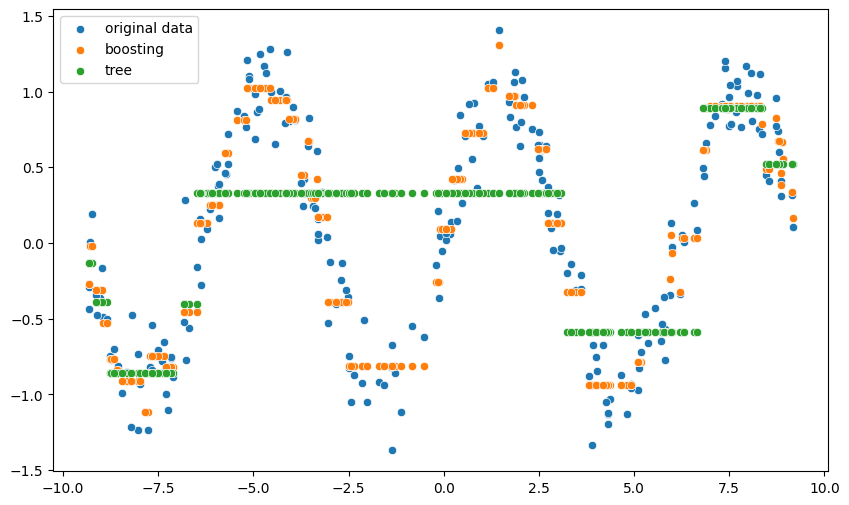

In [ ]:
import seaborn as sns

# генерируем данные
np.random.seed(42)
x = np.random.uniform(low=-3 * np.pi, high=3 * np.pi, size=(250))
y = np.sin(x) + np.random.randn(250) * 0.2

# обучаем обычное дерево глубины 3
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(x.reshape(-1, 1), y)

# обучаем бустинг-ансамбль
clf = GradientTreeBoosting(
    loss="MSE", iterations=10, learning_rate=0.8, max_depth=3, random_state=42
)
clf.fit(x.reshape(-1, 1), y)

# смотрим, что вышло
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, label="original data")
sns.scatterplot(x=x, y=clf.predict(x.reshape(-1, 1)), label="boosting")
sns.scatterplot(x=x, y=tree.predict(x.reshape(-1, 1)), label="tree")
plt.show()

Примените алгоритм к тем же данным, с которыми работали в предыдущем задании. Предсказывать будем не класс (0/1), а логиты, то есть вероятность того, что клиент уйдёт, и на основе неё уже делать прогноз, определяя класс относительно некого порога (по умолчанию 0.5).

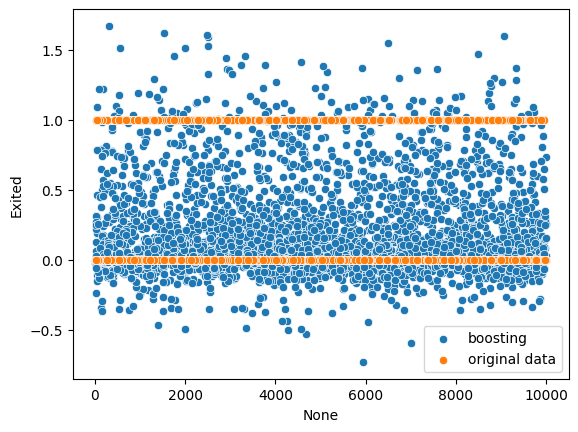

In [ ]:
my_GBDT = GradientTreeBoosting(
    loss="MSE", iterations=100, learning_rate=0.7, max_depth=5, random_state=42
)
my_GBDT.fit(X_train, y_train)
y_pred = my_GBDT.predict(X_test)

sns.scatterplot(x=X_test.index, y=y_pred, label="boosting")
sns.scatterplot(x=X_test.index, y=y_test, label="original data")
plt.show()


In [ ]:
def decide_class(logits, threshold=0.5):
    res = np.zeros(logits.shape[0])
    res[logits >= threshold] = 1
    return res

In [ ]:
y_pred = decide_class(y_pred, threshold=0.5)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2379
           1       0.58      0.52      0.55       621

    accuracy                           0.82      3000
   macro avg       0.73      0.71      0.72      3000
weighted avg       0.82      0.82      0.82      3000




Сравните вашу реализацию градиентного бустинга (с константным $\rho$ и нет) с одиночным DecisionTreeRegressor по качеству и времени выполнения. При неконстантном $\rho$ качество должно возрасти.

In [ ]:
param_grid = {
    "loss": ["MSE", "MAE", "lq"],
    "iterations": [50, 100, 200, 300],
    "learning_rate": [0.3, 0.7, 0.9, 1],
    "max_depth": [2, 5, 10],
}

best_recall = 0
best_params = {}

for combo in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    my_GBDT = GradientTreeBoosting(**params)

    my_GBDT.fit(X_train, y_train)
    y_pred = decide_class(my_GBDT.predict(X_test))

    recall = recall_score(y_test, y_pred)

    if recall > best_recall:
        best_recall = recall
        best_params = params
        print(f"New best: Recall {best_recall:.4f} with {params}")


print("\nBest model:")
print(f"Recall: {best_recall:.4f}")
print("Parameters:", best_params)

New best: Recall 0.4879 with {'loss': 'MSE', 'iterations': 50, 'learning_rate': 0.3, 'max_depth': 2}
New best: Recall 0.5217 with {'loss': 'MSE', 'iterations': 50, 'learning_rate': 0.3, 'max_depth': 5}
New best: Recall 0.5427 with {'loss': 'MSE', 'iterations': 50, 'learning_rate': 0.3, 'max_depth': 10}
New best: Recall 0.5572 with {'loss': 'MSE', 'iterations': 50, 'learning_rate': 0.7, 'max_depth': 10}
New best: Recall 0.5652 with {'loss': 'MAE', 'iterations': 50, 'learning_rate': 0.7, 'max_depth': 2}
New best: Recall 0.5717 with {'loss': 'MAE', 'iterations': 50, 'learning_rate': 0.7, 'max_depth': 10}
New best: Recall 0.6184 with {'loss': 'MAE', 'iterations': 50, 'learning_rate': 0.9, 'max_depth': 2}

Best model:
Recall: 0.6184
Parameters: {'loss': 'MAE', 'iterations': 50, 'learning_rate': 0.9, 'max_depth': 2}


In [ ]:
%%time

my_GBDT = GradientTreeBoosting(random_state=42, **best_params)
my_GBDT.fit(X_train, y_train)
y_pred = decide_class(my_GBDT.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2379
           1       0.52      0.62      0.57       621

    accuracy                           0.80      3000
   macro avg       0.71      0.74      0.72      3000
weighted avg       0.82      0.80      0.81      3000

CPU times: total: 688 ms
Wall time: 845 ms


In [ ]:
%%time
tree = DecisionTreeRegressor(max_depth=2, random_state=42)
tree.fit(X_train, y_train)
y_pred = decide_class(tree.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2379
           1       0.64      0.48      0.55       621

    accuracy                           0.84      3000
   macro avg       0.76      0.70      0.72      3000
weighted avg       0.82      0.84      0.83      3000

CPU times: total: 31.2 ms
Wall time: 40 ms
